In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils import weight_norm
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time
import pandas as pd

import sys



In [6]:
from Model import TemporalConvNet, Encoder, Decoder, Transformer

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.benchmark = True
# torch.backends.cudnn.deterministic = True

from or_DHW_create_dataset import get_DataLoader
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
## data.npy是只维持4个步长的，optSOCdata.npy是全发1的
data = np.array(pd.read_csv('0803 extended data 3.csv')[["ls", "p_flex"]])[206*96*2:,]
power = np.array(pd.read_csv('data/0728 200user.csv')[["p_norm"]])[:-96*3, ] 
batch_sz = 192 * 1
# load data
train_loader, val_loader, test_input, test_output, test_LS = get_DataLoader(data, power, batch_sz)

the max value of dim0 is:1.0, the min value is:0.0
the max value of dim1 is:1.0, the min value is:0.0
train_input.shape: torch.Size([39222, 192, 1]), train_output.shape: torch.Size([39222, 96, 1]), 
val_input.shape: torch.Size([0, 192, 1]), val_output.shape: torch.Size([0, 96, 1])


In [7]:
print(test_input.shape, test_output.shape, test_LS.shape)

torch.Size([14709, 192, 1]) torch.Size([15121, 96, 1]) torch.Size([15121, 96])


In [8]:
test_input = test_input[-60*206:-30*206, :, :]
test_output = test_output[-60*206:-30*206, :, :]
test_LS = test_LS[-60*206:-30*206, :]
print(test_output.shape)

torch.Size([6180, 96, 1])


In [6]:
model.load_state_dict(torch.load ('models/0804 Transformer_model e-05.pt', map_location='cpu'))

<All keys matched successfully>

In [7]:
def translate_sentence(src, LS, model, max_len=96):
    model.eval()
    LS = LS.to(device)
    src_tensor = src.to(device)
    src_tensor = model.downsample_cnn(src_tensor.permute(0,2,1)).permute(0,2,1)
    src_tensor = src_tensor[:,-96:,:]
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = torch.zeros(src.shape[0], 1, 1).to(device)

    for i in range(max_len):

        trg_tensor = torch.cat((trg_indexes, LS[:, :i+1, :]), dim=2)

        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        trg_indexes = torch.cat((trg_indexes, output[:, -1:, :]), dim=1)

    return trg_indexes[:, 1:, :], attention



In [ ]:
# cur_times = 10  #拆开数据后的计算次数，直接计算会显存不足
# batch = test_input.shape[0]/cur_times #注意一定要能被整除
# batch = int(batch)

# predicted_output = torch.Tensor([])
# for i in range(cur_times):

#     temp, _ = translate_sentence(torch.Tensor(test_input[batch * i:batch * (i+1)]),torch.Tensor(test_LS[batch * i:batch * (i+1)]),\
#                               model)
#     predicted_output = torch.cat((predicted_output, temp.cpu().detach()), dim=0)

# predicted_output = predicted_output.numpy()


In [9]:
predicted_output = np.load('0804 or_predicted_output.npy')
test_output = test_output.numpy()

In [10]:
test_output[0]

array([[0.03793333],
       [0.03213333],
       [0.13080001],
       [0.16406667],
       [0.1748    ],
       [0.42546666],
       [0.665     ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.   

In [11]:
# 存30天的metrics
#反归一化
data = np.array(pd.read_csv('0803 extended data 3.csv')[["ls", "p_flex"]])[206*96*2:,]
min_p = data[:,1].min()
max_p = data[:,1].max()
pre_output = (max_p - min_p)*predicted_output + min_p
real_output = (max_p - min_p)*test_output + min_p


In [12]:
pre_output

array([[[24.946194  ],
        [23.147163  ],
        [80.21556   ],
        ...,
        [ 0.7058367 ],
        [ 0.66024363],
        [ 1.069855  ]],

       [[ 1.6936339 ],
        [22.560637  ],
        [83.38036   ],
        ...,
        [ 0.59415627],
        [ 0.5570971 ],
        [ 0.6725751 ]],

       [[ 1.6936339 ],
        [ 1.7619766 ],
        [85.3482    ],
        ...,
        [ 0.46990067],
        [ 0.44306293],
        [ 0.63732636]],

       ...,

       [[ 1.6936384 ],
        [ 1.7619743 ],
        [ 1.8801123 ],
        ...,
        [ 1.8080927 ],
        [ 1.8055446 ],
        [ 1.7902739 ]],

       [[ 1.6936384 ],
        [ 1.7619743 ],
        [ 1.8801123 ],
        ...,
        [ 1.8080927 ],
        [ 1.8055446 ],
        [ 1.7902739 ]],

       [[ 1.6936384 ],
        [ 1.7619743 ],
        [ 1.8801123 ],
        ...,
        [ 1.8080927 ],
        [ 1.8055446 ],
        [ 1.7902739 ]]], dtype=float32)

In [27]:
# 求30天的metrics
# TCN_RMSE_UP = []
# TCN_MAE_UP = []
# for i in range(29):
    rmse = np.sqrt(np.mean(np.power((real_flex_up[i] - pre_flex_up[i]),2)))
    mae = np.mean(abs(real_flex_up[i] - pre_flex_up[i]))
#     TCN_RMSE_UP.append(rmse)
#     TCN_MAE_UP .append(mae)
# TCN_RMSE_UP = np.array(TCN_RMSE_UP)
# TCN_MAE_UP = np.array(TCN_MAE_UP)

In [31]:
206*30

6180

In [13]:
oneday = 206
def metrics (pre,real,oneday):
    pre_up = []
    pre_down = []
    real_up = []
    real_down = []
    for i in range(30):
        pre_up.append(pre[i*oneday : i*oneday + 96:,:,])
        real_up.append(real[i*oneday : i*oneday + 96:,:,])
        pre_down.append(pre[i*oneday + 96 : i*oneday + 96*2:,:,])
        real_down.append(real[i*oneday + 96 : i*oneday + 96*2:,:,])
    pre_up = np.array(pre_up)
    real_up = np.array(real_up)
    pre_down = np.array(pre_down)
    real_down = np.array(real_down)
    
    Tans_RMSE_UP = []
    Tans_RMSE_DOWN = []
    Tans_MAE_UP = []
    Tans_MAE_DOWN = []
    for i in range(30):
        rmse_up = np.sqrt(np.mean(np.power((real_up[i] - pre_up[i]),2)))
        mae_up = np.mean(abs(real_up[i] - pre_up[i]))
        rmse_down= np.sqrt(np.mean(np.power((real_down[i] - pre_down[i]),2)))
        mae_down = np.mean(abs(real_down[i] - pre_down[i]))
        Tans_RMSE_UP.append(rmse_up)
        Tans_RMSE_DOWN .append(rmse_down)
        Tans_MAE_UP.append(mae_up)
        Tans_MAE_DOWN .append(mae_down)
    Tans_RMSE_UP = np.array(Tans_RMSE_UP)
    Tans_RMSE_DOWN = np.array(Tans_RMSE_DOWN)
    Tans_MAE_UP = np.array(Tans_MAE_UP)
    Tans_MAE_DOWN = np.array(Tans_MAE_DOWN)
    return Tans_RMSE_UP,Tans_RMSE_DOWN,Tans_MAE_UP,Tans_MAE_DOWN
    
    
    
        
        
    

In [14]:
Tans_RMSE_UP,Tans_RMSE_DOWN,Tans_MAE_UP,Tans_MAE_DOWN = metrics(pre_output, real_output,206)

In [27]:
np.save('metrics/or_Tans_RMSE_UP',Tans_RMSE_UP)
np.save('metrics/or_Tans_RMSE_DOWN',Tans_RMSE_DOWN)
np.save('metrics/or_Tans_MAE_UP',Tans_MAE_UP)
np.save('metrics/or_Tans_MAE_DOWN',Tans_MAE_DOWN)

In [25]:
print("Tans_RMSE_UP:Mean:{:.3f},Max:{:.3f},Min:{:.3f}".format(np.mean(Tans_RMSE_UP),np.max(Tans_RMSE_UP),np.min(Tans_RMSE_UP)))
print("Tans_MAE_UP:Mean:{:.3f},Max:{:.3f},Min:{:.3f}".format(np.mean(Tans_MAE_UP),np.max(Tans_MAE_UP),np.min(Tans_MAE_UP)))
print("Tans_RMSE_down:Mean:{:.3f},Max:{:.3f},Min:{:.3f}".format(np.mean(Tans_RMSE_DOWN),np.max(Tans_RMSE_DOWN),np.min(Tans_RMSE_DOWN)))
print("Tans_MAE_down:Mean:{:.3f},Max:{:.3f},Min:{:.3f}".format(np.mean(Tans_MAE_DOWN),np.max(Tans_MAE_DOWN),np.min(Tans_MAE_DOWN)))

Tans_RMSE_UP:Mean:8.224,Max:11.985,Min:6.199
Tans_MAE_UP:Mean:3.051,Max:3.986,Min:2.572
Tans_RMSE_down:Mean:7.887,Max:10.158,Min:6.190
Tans_MAE_down:Mean:3.105,Max:3.746,Min:2.700


In [17]:
pre_up = []
pre_down = []
real_up = []
real_down = []
for i in range(30):
    pre_up.append(pre_output[i*oneday : i*oneday + 96:,:,])
    real_up.append(real_output[i*oneday : i*oneday + 96:,:,])
    pre_down.append(pre_output[i*oneday + 96 : i*oneday + 96*2:,:,])
    real_down.append(real_output[i*oneday + 96 : i*oneday + 96*2:,:,])
pre_up = np.array(pre_up)
real_up = np.array(real_up)
pre_down = np.array(pre_down)
real_down = np.array(real_down)

In [18]:
# 画效果图
real_flex_up1 = real_up[1].reshape(96,96,1)
real_flex_down1 = real_down[2].reshape(96,96,1)
pre_flex_up1 = pre_up[1].reshape(96,96,1)
pre_flex_down1 = pre_down[2].reshape(96,96,1)

In [19]:
#生成灵活度表征函数
#上备用

real_up_1step=[]
for i in range(96):
    a=real_flex_up1[i][i]
    real_up_1step.append(a)
real_up_1step=np.array(real_up_1step)

real_up_2step=[]
for i in range(48):
    a=[real_flex_up1[i][i],real_flex_up1[i][i+1]]
    b=np.min(a)
    real_up_2step.append(b)
    real_up_2step.append(b)
real_up_2step=np.array(real_up_2step)

real_up_4step=[]
for i in range(24):
    a=[real_flex_up1[i][i],real_flex_up1[i][i+1],real_flex_up1[i][i+2],real_flex_up1[i][i+3]]
    b=np.min(a)
    real_up_4step.append(b)
    real_up_4step.append(b)
    real_up_4step.append(b)
    real_up_4step.append(b)
real_up_4step=np.array(real_up_4step)
 
 



In [20]:
pre_up_1step=[]
for i in range(96):
    a=pre_flex_up1[i][i]
    pre_up_1step.append(a)
pre_up_1step=np.array(pre_up_1step)

pre_up_2step=[]
for i in range(48):
    a=[pre_flex_up1[i][i],pre_flex_up1[i][i+1]]
    b=np.min(a)
    pre_up_2step.append(b)
    pre_up_2step.append(b)
pre_up_2step=np.array(pre_up_2step)

pre_up_4step=[]
for i in range(24):
    a=[pre_flex_up1[i][i],pre_flex_up1[i][i+1],pre_flex_up1[i][i+2],pre_flex_up1[i][i+3]]
    b=np.min(a)
    pre_up_4step.append(b)
    pre_up_4step.append(b)
    pre_up_4step.append(b)
    pre_up_4step.append(b)
pre_up_4step=np.array(pre_up_4step)

In [21]:
#下备用
real_down_1step=[]
for i in range(96):
    a=real_flex_down1[i][i]
    real_down_1step.append(a)
real_down_1step=np.array(real_down_1step)

real_down_2step=[]
for i in range(48):
    a=[real_flex_down1[i][i],real_flex_down1[i][i+1]]
    b=np.min(a)
    real_down_2step.append(b)
    real_down_2step.append(b)
real_down_2step=np.array(real_down_2step)

real_down_4step=[]
for i in range(24):
    a=[real_flex_down1[i][i],real_flex_down1[i][i+1],real_flex_down1[i][i+2],real_flex_down1[i][i+3]]
    b=np.min(a)
    real_down_4step.append(b)
    real_down_4step.append(b)
    real_down_4step.append(b)
    real_down_4step.append(b)
real_down_4step=np.array(real_down_4step)

In [22]:
pre_down_1step=[]
for i in range(96):
    a=pre_flex_down1[i][i]
    pre_down_1step.append(a)
pre_down_1step=np.array(pre_down_1step)

pre_down_2step=[]
for i in range(48):
    a=[pre_flex_down1[i][i],pre_flex_down1[i][i+1]]
    b=np.min(a)
    pre_down_2step.append(b)
    pre_down_2step.append(b)
pre_down_2step=np.array(pre_down_2step)

pre_down_4step=[]
for i in range(24):
    a=[pre_flex_down1[i][i],pre_flex_down1[i][i+1],pre_flex_down1[i][i+2],pre_flex_down1[i][i+3]]
    b=np.min(a)
    pre_down_4step.append(b)
    pre_down_4step.append(b)
    pre_down_4step.append(b)
    pre_down_4step.append(b)
pre_down_4step=np.array(pre_down_4step)

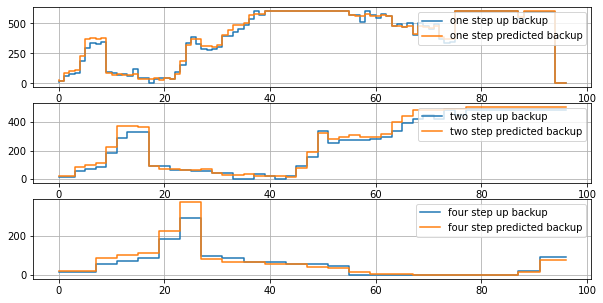

In [28]:
#画图
plt.figure(figsize=(10,5))
ax1 = plt.subplot(311)
x1=np.linspace(0,96,96).astype(int)
l1=plt.step(x1,real_up_1step,label='one step up backup')
l2=plt.step(x1,pre_up_1step,label='one step predicted backup')
plt.legend(loc = 'upper right')
# plt.yticks(y)
plt.grid()

ax2 = plt.subplot(312)
l1=plt.step(x1,real_up_2step,label='two step up backup')
l2=plt.step(x1,pre_up_2step,label='two step predicted backup')
plt.legend(loc = 'upper right')
# plt.yticks(y)
plt.grid()

ax3 = plt.subplot(313)
l1=plt.step(x1,real_up_4step,label='four step up backup')
l2=plt.step(x1,pre_up_4step,label='four step predicted backup')
plt.legend(loc = 'upper right')
# plt.yticks(y)
plt.grid()

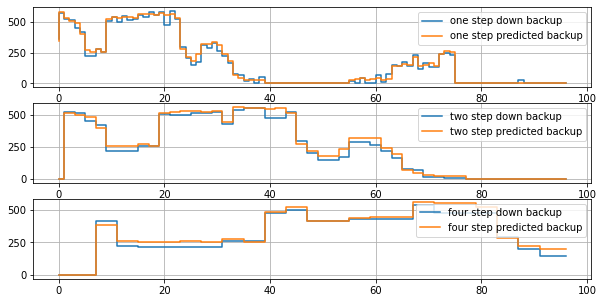

In [29]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(311)
x1=np.linspace(0,96,96).astype(int)
l1=plt.step(x1,real_down_1step,label='one step down backup')
l2=plt.step(x1,pre_down_1step,label='one step predicted backup')
plt.legend(loc = 'upper right')
# plt.yticks(y)
plt.grid()

ax2 = plt.subplot(312)
l1=plt.step(x1,real_down_2step,label='two step down backup')
l2=plt.step(x1,pre_down_2step,label='two step predicted backup')
plt.legend(loc = 'upper right')
# plt.yticks(y)
plt.grid()

ax3 = plt.subplot(313)
l1=plt.step(x1,real_down_4step,label='four step down backup')
l2=plt.step(x1,pre_down_4step,label='four step predicted backup')
plt.legend(loc = 'upper right')
# plt.yticks(y)
plt.grid()



plt.show()

In [ ]:
# data = {'TRAN_real_up_1step':real_up_1step,'TRAN_real_up_2step':real_up_2step,'TRAN_real_up_4step':real_up_4step,'TRAN_pre_up_1step':pre_up_1step,
#        'TRAN_pre_up_2step':pre_up_2step,'TRAN_pre_up_4step':pre_up_4step,'TRAN_real_down_1step':real_down_1step,'TRAN_real_down_2step':real_down_2step,
#         'TRAN_real_down_4step':real_down_4step,'TRAN_pre_down_1step':pre_down_1step,'TRAN_pre_down_2step':pre_down_2step,'TRAN_pre_down_4step':pre_down_4step}
# pd.DataFrame(data).to_csv('flew2draw/transformer flex2draw.csv')

In [30]:
data = {'TRAN_real_up_1step':real_up_1step.reshape(-1),'TRAN_real_up_2step':real_up_2step.reshape(-1),'TRAN_real_up_4step':real_up_4step.reshape(-1),'TRAN_pre_up_1step':pre_up_1step.reshape(-1),
       'TRAN_pre_up_2step':pre_up_2step.reshape(-1),'TRAN_pre_up_4step':pre_up_4step.reshape(-1),'TRAN_real_down_1step':real_down_1step.reshape(-1),'TRAN_real_down_2step':real_down_2step.reshape(-1),
        'TRAN_real_down_4step':real_down_4step.reshape(-1),'TRAN_pre_down_1step':pre_down_1step.reshape(-1),'TRAN_pre_down_2step':pre_down_2step.reshape(-1),'TRAN_pre_down_4step':pre_down_4step.reshape(-1)}
df = pd.DataFrame(data)
df.to_csv('flex2draw/or_tansformer_flex2draw.csv')